In [1]:
import pandas as pd
import numpy as np
import random
random.seed(15)
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from HEMS_function import financial_gain, financial_gain_noheat
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=FutureWarning)

## Some input files are required. Run HEMS-upload.ipynb to obtain the required files

In [2]:
path=r"/Users/z102933/Desktop/PhD/Data/ABM/"
results_hp_pv=pd.read_pickle(f"{path}2019_results_hp_pv_upload.pkl") #done
results_hp_nopv=pd.read_pickle(rf"{path}/2019_results_hp_nopv_upload.pkl") #done
results_nohp_nopv=pd.read_pickle(rf"{path}/2019_results_nohp_nopv_upload.pkl") #done
results_nohp_pv=pd.read_pickle(rf"{path}/2019_results_nohp_pv_upload.pkl") #done
results_hp=pd.read_pickle(rf"{path}/2019_results_hp_upload.pkl") #done
avg_running_cost=pd.read_pickle(rf"{path}/2019_avgrunningcosts_upload.pkl") #done
results_savings_hp_DR=-pd.DataFrame(results_hp_nopv["P (H)(kW)"].groupby(pd.Grouper(freq='M')).sum()-\
                                        results_hp["P (H)(kW)"].groupby(pd.Grouper(freq='M')).sum())
results_savings_pv_DR=pd.DataFrame(results_nohp_nopv["From grid"].groupby(pd.Grouper(freq='M')).sum()-\
                                    results_nohp_nopv["To grid"].groupby(pd.Grouper(freq='M')).sum()-\
                                    (results_nohp_pv["From grid"].groupby(pd.Grouper(freq='M')).sum()-\
                                    results_nohp_pv["To grid"].groupby(pd.Grouper(freq='M')).sum()))
#results_savings_hp_DR=pd.read_pickle(rf"{path}/2019_1_results_savings_hp_DR.pkl") 
#results_savings_pv_DR=pd.read_pickle(rf"{path}/2019_1_results_savings_pv_DR.pkl")
enrollment_rate_1=pd.DataFrame(index=range(12),columns=["Enrollment 1","Enrollment 2","Enrollment 3","Enrollment 4"])
enrollment_rate_hp=pd.DataFrame(index=range(12),columns=["Enrollment 1","Enrollment 2","Enrollment 3","Enrollment 4","Savings 1","Savings 2",\
                                                            "Savings 3","Savings 4"])
enrollment_rate_pv=pd.DataFrame(index=range(12),columns=["Enrollment 1","Enrollment 2","Enrollment 3","Enrollment 4","Savings 1","Savings 2",\
                                                            "Savings 3","Savings 4"])
start_month=results_savings_hp_DR.index+ pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(normalize=True)

### In this, we are simulating 240 consumers living in 4 different neighborhoods. Each agent/consumer has 2 friends within the same neighborhood and 2 friends outside the neighborhood. The share of consumers having electric heating is 60% and the share of consumers having PV+BESS in their hosuehold is 10%. The expected conmpensation depends on the availability of household loads and are randomly assigned. 

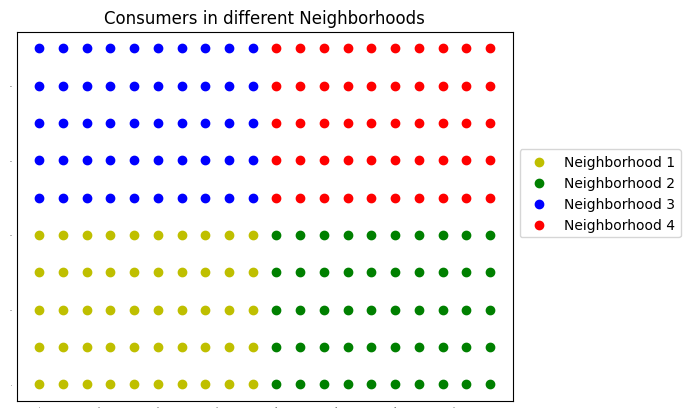

In [3]:
consumers=200 #Set the number of consumers in the analysis
n_friend_1=2 #Set the number of friends within the same neighborhood
n_friend_2=2 #Set the number of friends outside the neighborhood
electric_heating_share=0.6 #Share of electric heating consumers in the analysis
savings_factor=1 #Set the scaling factor for expected annual savings
pv_share=0.1 #Share of PV+BESS consumers in the analysis
if consumers%4!=0:
    raise ValueError("Consumers not divisible by 4")
consumer_database=pd.DataFrame(index=range(consumers),columns=["ID", "Neighborhood", "Friend group 1", "Friend group 2", "Heating",
                                                               "PV+BESS", "Expected Annual Savings","X","Y","Monthly savings from DR",
                                                               "Monthly expected savings","Monthly financial delta", "Monthly percentage delta",\
                                                               "Satisfaction","Enrollment","Enrollment months", "w_friends", "w_neighborhood",\
                                                               "w_personal"])
heating=[]
neighborhood=[]
pv=[]
for i in range(len(consumer_database)):
    consumer_database["ID"].iloc[i]=i
    consumer_database["Neighborhood"].iloc[i]=random.randrange(1,5)
    if i<int(electric_heating_share*consumers): 
        heating.append(1)
    else:
        heating.append(0)
    if i<int(pv_share*consumers): 
        pv.append(1)
    else:
        pv.append(0)
    if i<consumers/4:
        neighborhood.append(1)
    elif i>=consumers/4 and i<consumers/2:
        neighborhood.append(2)
    elif i>=consumers/2 and i<consumers*0.75:
        neighborhood.append(3)
    else:
        neighborhood.append(4)

for i in range(len(consumer_database)):
    n=random.randrange(0,len(neighborhood))
    consumer_database["Neighborhood"].iloc[i]=neighborhood[n]
    neighborhood.pop(n)

neighborhood_1=[]
neighborhood_2=[]
neighborhood_3=[]
neighborhood_4=[]
for i in range(len(consumer_database)):
    if consumer_database["Neighborhood"].iloc[i]==1:
        neighborhood_1.append(consumer_database["ID"].iloc[i])
    elif consumer_database["Neighborhood"].iloc[i]==2:
        neighborhood_2.append(consumer_database["ID"].iloc[i])
    elif consumer_database["Neighborhood"].iloc[i]==3:
        neighborhood_3.append(consumer_database["ID"].iloc[i])
    elif consumer_database["Neighborhood"].iloc[i]==4:
        neighborhood_4.append(consumer_database["ID"].iloc[i])
    else:
        raise ValueError("ERROR!!! CHECK!!")
    consumer_database["w_friends"].iloc[i]=round(random.uniform(0.00, 0.50),2) #Randomly assigning weight of friends
    consumer_database["w_neighborhood"].iloc[i]=round(random.uniform(0.00, 0.50),2) #Randomly assigning weight of neighborhood
    consumer_database["w_personal"].iloc[i]=1-consumer_database["w_friends"].iloc[i]-consumer_database["w_neighborhood"].iloc[i]
for i in range(len(consumer_database)):
    friend_1=[]
    friend_2=[]
    outside_neighbourhood=[]
    consumer_database["Satisfaction"].iloc[i]=[]
    consumer_database["Enrollment"].iloc[i]=[]
    consumer_database["Enrollment months"].iloc[i]=[]
    consumer_database["Monthly percentage delta"].iloc[i]=[]
    if consumer_database["Neighborhood"].iloc[i]==1:
        for j in range(n_friend_1):
            friend_1.append(neighborhood_1[random.randrange(0,len(neighborhood_1))])
        outside_neighbourhood.extend(neighborhood_2[:])
        outside_neighbourhood.extend(neighborhood_3)
        outside_neighbourhood.extend(neighborhood_4)
        for j in range(n_friend_2):
            friend_2.append(outside_neighbourhood[random.randrange(0,len(outside_neighbourhood))])
    elif consumer_database["Neighborhood"].iloc[i]==2:
        for j in range(n_friend_1):
            friend_1.append(neighborhood_2[random.randrange(0,len(neighborhood_2))])
        outside_neighbourhood.extend(neighborhood_1)
        outside_neighbourhood.extend(neighborhood_3)
        outside_neighbourhood.extend(neighborhood_4)
        for j in range(n_friend_2):
            friend_2.append(outside_neighbourhood[random.randrange(0,len(outside_neighbourhood))])
    elif consumer_database["Neighborhood"].iloc[i]==3:
        for j in range(n_friend_1):
            friend_1.append(neighborhood_3[random.randrange(0,len(neighborhood_3))])
        outside_neighbourhood.extend(neighborhood_1)
        outside_neighbourhood.extend(neighborhood_2)
        outside_neighbourhood.extend(neighborhood_4)
        for j in range(n_friend_2):
            friend_2.append(outside_neighbourhood[random.randrange(0,len(outside_neighbourhood))])
    elif consumer_database["Neighborhood"].iloc[i]==4:
        for j in range(n_friend_1):
            friend_1.append(neighborhood_4[random.randrange(0,len(neighborhood_4))])
        outside_neighbourhood.extend(neighborhood_1)
        outside_neighbourhood.extend(neighborhood_2)
        outside_neighbourhood.extend(neighborhood_3)
        for j in range(n_friend_2):
            friend_2.append(outside_neighbourhood[random.randrange(0,len(outside_neighbourhood))])
    consumer_database["Friend group 1"].iloc[i]=friend_1
    consumer_database["Friend group 2"].iloc[i]=friend_2
    c=random.randrange(0,len(heating))
    consumer_database["Heating"].iloc[i]=heating[c]
    heating.pop(c)
    p=random.randrange(0,len(pv))
    consumer_database["PV+BESS"].iloc[i]=pv[p]
    pv.pop(p)
    if consumer_database["Heating"].iloc[i]==1: #Compensation expected for consumers with HP
        if consumer_database["PV+BESS"].iloc[i]==0:
            consumer_database["Expected Annual Savings"].iloc[i]=savings_factor*int(random.uniform(50,200)) 
        else:
            consumer_database["Expected Annual Savings"].iloc[i]=savings_factor*int(random.uniform(150,400))             
    else: #Compensation expected for consumers without HP 
        if consumer_database["PV+BESS"].iloc[i]==0:
            consumer_database["Expected Annual Savings"].iloc[i]=savings_factor*int(random.uniform(10,50))
        else:
            consumer_database["Expected Annual Savings"].iloc[i]=savings_factor*int(random.uniform(50,200))            


consumer_database=consumer_database.set_index("ID")

x=0
y=0        
for i in range(len(consumer_database)):
    if consumer_database["Neighborhood"].iloc[i]==1:
        consumer_database["X"].iloc[i]=x
        consumer_database["Y"].iloc[i]=y
        x=x+10
        if x%(consumers/2)==0:
            x=0
            y=y+10
x=consumers/2
y=0        
for i in range(len(consumer_database)):
    if consumer_database["Neighborhood"].iloc[i]==2:
        consumer_database["X"].iloc[i]=x
        consumer_database["Y"].iloc[i]=y
        x=x+10
        if x%(consumers/2)==0:
            x=(consumers/2)
            y=y+10
x=0
y_1=y
y=y_1     
for i in range(len(consumer_database)):
    if consumer_database["Neighborhood"].iloc[i]==3:
        consumer_database["X"].iloc[i]=x
        consumer_database["Y"].iloc[i]=y
        x=x+10
        if x%(consumers/2)==0:
            x=0
            y=y+10
x=(consumers/2)
y=y_1        
for i in range(len(consumer_database)):
    if consumer_database["Neighborhood"].iloc[i]==4:
        consumer_database["X"].iloc[i]=x
        consumer_database["Y"].iloc[i]=y
        x=x+10
        if x%(consumers/2)==0:
            x=(consumers/2)
            y=y+10

for i in range((len(consumer_database))):
    if consumer_database["PV+BESS"].iloc[i]==0 and consumer_database["Heating"].iloc[i]==0:
        consumer_database["Monthly savings from DR"].iloc[i],consumer_database["Monthly financial delta"].iloc[i],\
        consumer_database["Monthly expected savings"].iloc[i]=\
            financial_gain_noheat(results_nohp_nopv, consumer_database["Expected Annual Savings"].iloc[i], avg_running_cost)
    elif consumer_database["PV+BESS"].iloc[i]==1 and consumer_database["Heating"].iloc[i]==0:
        consumer_database["Monthly savings from DR"].iloc[i],consumer_database["Monthly financial delta"].iloc[i],\
            consumer_database["Monthly expected savings"].iloc[i]=\
            financial_gain_noheat(results_nohp_pv, consumer_database["Expected Annual Savings"].iloc[i], avg_running_cost)
    elif consumer_database["Heating"].iloc[i]==1 and consumer_database["PV+BESS"].iloc[i]==1:
        consumer_database["Monthly savings from DR"].iloc[i],consumer_database["Monthly financial delta"].iloc[i],\
            consumer_database["Monthly expected savings"].iloc[i]=\
            financial_gain(results_hp_pv, consumer_database["Expected Annual Savings"].iloc[i], avg_running_cost,results_hp)
    else:
        consumer_database["Monthly savings from DR"].iloc[i],consumer_database["Monthly financial delta"].iloc[i],\
            consumer_database["Monthly expected savings"].iloc[i]=\
            financial_gain(results_hp_nopv, consumer_database["Expected Annual Savings"].iloc[i], avg_running_cost,results_hp)

for j in range(12):
    for i in range(len(consumer_database)):
        consumer_database["Monthly percentage delta"].iloc[i].append(consumer_database["Monthly financial delta"].iloc[i][j]*100/\
            consumer_database["Monthly expected savings"].iloc[i][j])
        if consumer_database["Monthly percentage delta"].iloc[i][j]<=-25:
            consumer_database["Satisfaction"].iloc[i].append(1)
        elif consumer_database["Monthly percentage delta"].iloc[i][j]<=0:
            consumer_database["Satisfaction"].iloc[i].append(0.75)
        elif consumer_database["Monthly percentage delta"].iloc[i][j]<=25:
            consumer_database["Satisfaction"].iloc[i].append(0.5)
        elif consumer_database["Monthly percentage delta"].iloc[i][j]<=50:
            consumer_database["Satisfaction"].iloc[i].append(0.25)
        else:
            consumer_database["Satisfaction"].iloc[i].append(0)
            
plt.scatter(consumer_database["X"].loc[consumer_database["Neighborhood"]==1],consumer_database["Y"].loc[consumer_database["Neighborhood"]==1], c='y', label='Neighborhood 1')
plt.scatter(consumer_database["X"].loc[consumer_database["Neighborhood"]==2],consumer_database["Y"].loc[consumer_database["Neighborhood"]==2], c='g', label='Neighborhood 2')
plt.scatter(consumer_database["X"].loc[consumer_database["Neighborhood"]==3],consumer_database["Y"].loc[consumer_database["Neighborhood"]==3], c='b', label='Neighborhood 3')
#plt.axis('off')
plt.title(f"Consumers in different Neighborhoods")
plt.scatter(consumer_database["X"].loc[consumer_database["Neighborhood"]==4],consumer_database["Y"].loc[consumer_database["Neighborhood"]==4], c='r', label='Neighborhood 4')
plt.legend(bbox_to_anchor=(1, 0.7))
plt.tick_params(axis='both', labelsize=0, length = 0)


## Contract 1 where consumers can enroll and disenroll monthly

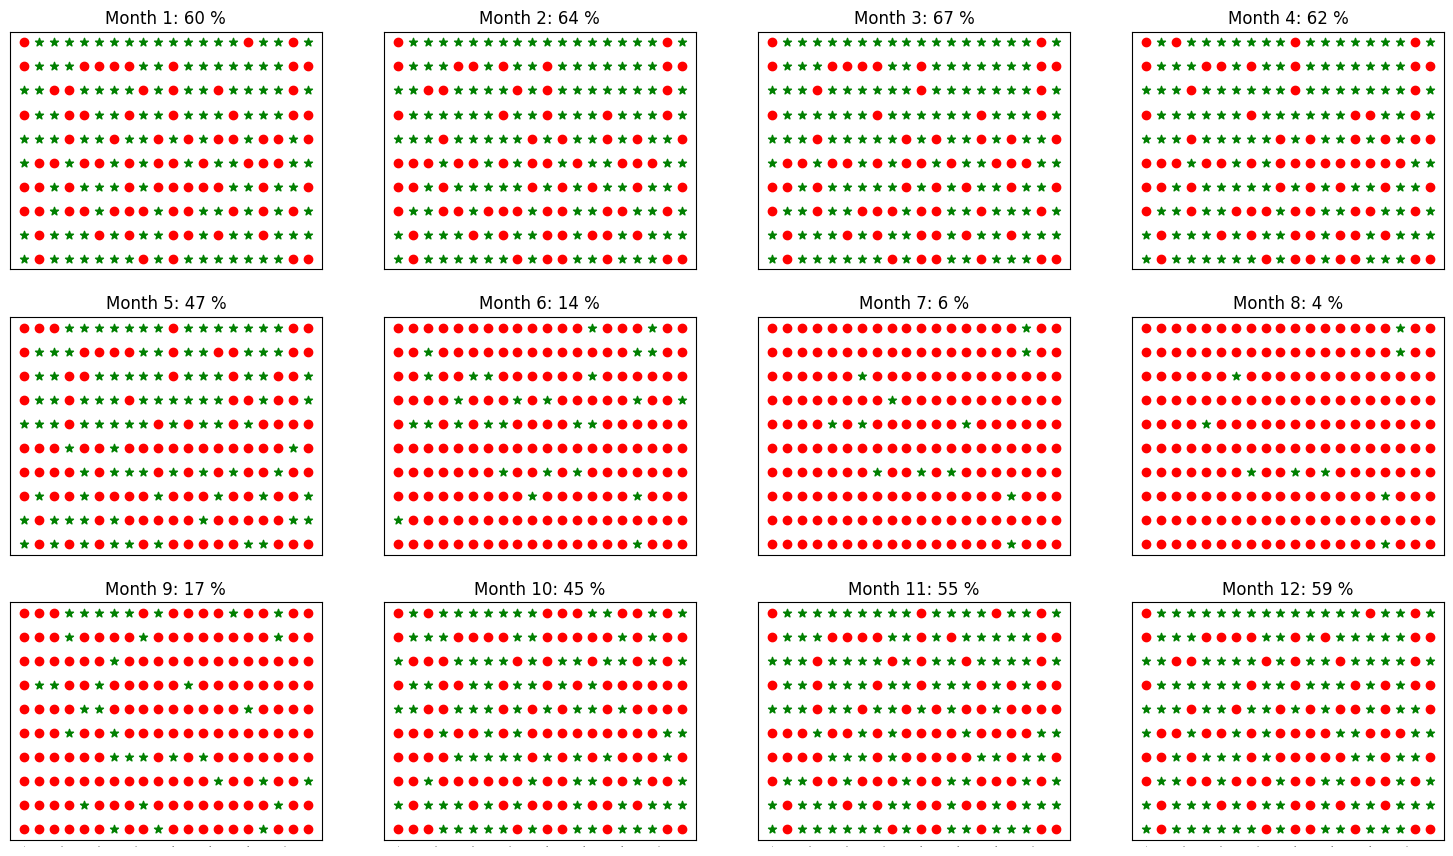

In [4]:
#BASIC MODEL WITH ENROLL & DEENROLL MONTHLY
for i in range(len(consumer_database)):
    #consumer_database["Satisfaction"].iloc[i]=[]
    consumer_database["Enrollment"].iloc[i]=[]
    consumer_database["Enrollment months"].iloc[i]=[]
for j in range(12):
    for i in range(len(consumer_database)):
        n=0
        friend=0
        weight_neighborhood=consumer_database["w_neighborhood"].iloc[i]
        weight_friends=consumer_database["w_friends"].iloc[i]
        weight_personal=consumer_database["w_personal"].iloc[i]
        if j==0:
            if consumer_database["Satisfaction"].iloc[i][j]==1:
                consumer_database["Enrollment"].iloc[i].append(1)
            else:
                consumer_database["Enrollment"].iloc[i].append(0)
        else:
            for k in range(n_friend_1):
                friend=friend+consumer_database["Satisfaction"].iloc[consumer_database["Friend group 1"].iloc[i][k]][j-1]
            for k in range(n_friend_2):
                friend=friend+consumer_database["Satisfaction"].iloc[consumer_database["Friend group 2"].iloc[i][k]][j-1]
            if consumer_database["Neighborhood"].iloc[i]==1:
                for k in neighborhood_1:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            elif consumer_database["Neighborhood"].iloc[i]==2:
                for k in neighborhood_2:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            elif consumer_database["Neighborhood"].iloc[i]==3:
                for k in neighborhood_3:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            else:
                for k in neighborhood_4:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            e=weight_neighborhood*(n*4/consumers)+weight_friends*(friend/(n_friend_2+n_friend_1))+\
                weight_personal*consumer_database["Satisfaction"].iloc[i][j]
            if e<0.5:
                enroll=0
            else:
                enroll=1
            consumer_database["Enrollment"].iloc[i].append(enroll)
plot_x=0
fig, axs = plt.subplots(3,4, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
for m in range(12):    
    enrolled=[]
    not_enrolled=[]
    c=0
    for i in range(len(consumer_database)):
        if consumer_database["Enrollment"].iloc[i][m]==1:
            enrolled.append(i)
            c=c+1
        else:
            not_enrolled.append(i)
    plot_y=m%4
    axs[plot_x,plot_y].scatter(consumer_database["X"].loc[enrolled],consumer_database["Y"].loc[enrolled],marker="*",color="g")
    axs[plot_x,plot_y].scatter(consumer_database["X"].loc[not_enrolled],consumer_database["Y"].loc[not_enrolled],marker="o",color="r")
    axs[plot_x,plot_y].set_yticks([])
    axs[plot_x,plot_y].set_title(f"Month {m+1}: {int(c*100/consumers)} %")
    #axs[plot_x,plot_y].tick_params(axis=u'both', which=u'both',length=0)
    axs[plot_x,plot_y].tick_params(axis='both', labelsize=0, length = 0)
    if plot_y==3:
        plot_x=plot_x+1
    enrollment_rate_1["Enrollment 1"].iloc[m]=int(c*100/consumers)
    consumer_hp_enrolled=consumer_database.loc[consumer_database["Heating"]==1].index.intersection(enrolled)
    enrollment_rate_hp["Enrollment 1"].iloc[m]=len(consumer_hp_enrolled)/(electric_heating_share*consumers)
    consumer_pv_enrolled=consumer_database.loc[consumer_database["PV+BESS"]==1].index.intersection(enrolled)
    if pv_share!=0:
        enrollment_rate_pv["Enrollment 1"].iloc[m]=len(consumer_pv_enrolled)/(pv_share*consumers)
    else:
        enrollment_rate_pv["Enrollment 1"].iloc[m]=0
#axs.tick_params(axis=u'both', which=u'both',length=0)        

## Contract 2 where consumers can decide to enroll in a 3 month rolling basis and then recide if they want to continue or not

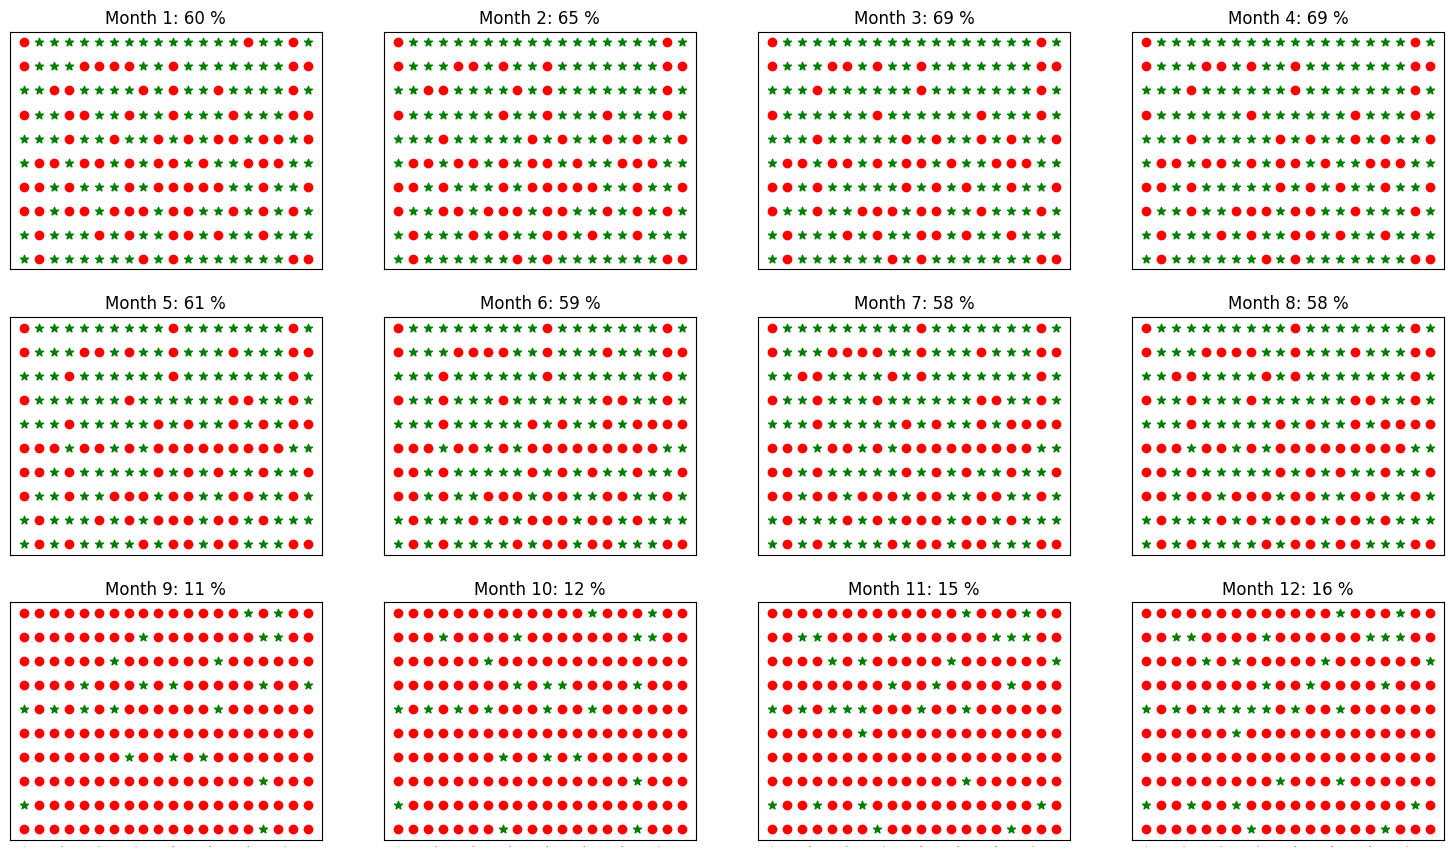

In [5]:
#BASIC MODEL WITH ENROLL for 3 month and only then can de enroll but binding for 3 months in repetition
consumer_database.loc[:,"Contract months"]=0
consumer_database.loc[:,"Accumulated personal satisfaction"]=0
for i in range(len(consumer_database)):
    #consumer_database["Satisfaction"].iloc[i]=[]
    consumer_database["Enrollment"].iloc[i]=[]
    consumer_database["Enrollment months"].iloc[i]=[]
for j in range(12):
    for i in range(len(consumer_database)):
        friend=0
        n=0
        weight_neighborhood=consumer_database["w_neighborhood"].iloc[i]
        weight_friends=consumer_database["w_friends"].iloc[i]
        weight_personal=consumer_database["w_personal"].iloc[i]
        if j==0:
            if consumer_database["Satisfaction"].iloc[i][j]==1:
                consumer_database["Enrollment"].iloc[i].append(1)
                consumer_database["Contract months"].iloc[i]=3
            else:
                consumer_database["Enrollment"].iloc[i].append(0)
                consumer_database["Contract months"].iloc[i]=0
        else:
            for k in range(n_friend_1):
                friend=friend+consumer_database["Satisfaction"].iloc[consumer_database["Friend group 1"].iloc[i][k]][j-1]
            for k in range(n_friend_2):
                friend=friend+consumer_database["Satisfaction"].iloc[consumer_database["Friend group 2"].iloc[i][k]][j-1]
            if consumer_database["Neighborhood"].iloc[i]==1:
                for k in neighborhood_1:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            elif consumer_database["Neighborhood"].iloc[i]==2:
                for k in neighborhood_2:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            elif consumer_database["Neighborhood"].iloc[i]==3:
                for k in neighborhood_3:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            else:
                for k in neighborhood_4:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            if consumer_database["Contract months"].iloc[i]==0:
                e=weight_neighborhood*(n*4/consumers)+weight_friends*(friend/(n_friend_2+n_friend_1))+\
                    weight_personal*(consumer_database["Satisfaction"].iloc[i][j]+\
                    consumer_database["Accumulated personal satisfaction"].iloc[i]/3)/2
                if e<0.5:
                    enroll=0
                    contract=0
                else:
                    enroll=1
                    contract=3
                consumer_database["Enrollment"].iloc[i].append(enroll)
                consumer_database["Contract months"].iloc[i]=contract
                consumer_database["Accumulated personal satisfaction"].iloc[i]=0
            else:
                consumer_database["Accumulated personal satisfaction"].iloc[i]=consumer_database["Accumulated personal satisfaction"].iloc[i]+\
                    consumer_database["Satisfaction"].iloc[i][j]
                consumer_database["Enrollment"].iloc[i].append(1)
                consumer_database["Contract months"].iloc[i]=consumer_database["Contract months"].iloc[i]-1
                
plot_x=0
fig, axs = plt.subplots(3,4, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
for m in range(12):    
    enrolled=[]
    not_enrolled=[]
    c=0
    for i in range(len(consumer_database)):
        if consumer_database["Enrollment"].iloc[i][m]==1:
            enrolled.append(i)
            c=c+1
        else:
            not_enrolled.append(i)
    plot_y=m%4
    axs[plot_x,plot_y].scatter(consumer_database["X"].loc[enrolled],consumer_database["Y"].loc[enrolled],marker="*",color="g")
    axs[plot_x,plot_y].scatter(consumer_database["X"].loc[not_enrolled],consumer_database["Y"].loc[not_enrolled],marker="o",color="r")
    axs[plot_x,plot_y].set_yticks([])
    axs[plot_x,plot_y].set_title(f"Month {m+1}: {int(c*100/consumers)} %")
    axs[plot_x,plot_y].tick_params(axis='both', labelsize=0, length = 0)
    if plot_y==3:
        plot_x=plot_x+1
    enrollment_rate_1["Enrollment 2"].iloc[m]=int(c*100/consumers)
    consumer_hp_enrolled=consumer_database.loc[consumer_database["Heating"]==1].index.intersection(enrolled)
    enrollment_rate_hp["Enrollment 2"].iloc[m]=len(consumer_hp_enrolled)/(consumers*electric_heating_share)
    consumer_pv_enrolled=consumer_database.loc[consumer_database["PV+BESS"]==1].index.intersection(enrolled)
    if pv_share!=0:
        enrollment_rate_pv["Enrollment 2"].iloc[m]=len(consumer_pv_enrolled)/(pv_share*consumers)
    else:
        enrollment_rate_pv["Enrollment 2"].iloc[m]=0

## Contract 3 where there is a 3 month binding period after which consumers can enroll disenroll freely

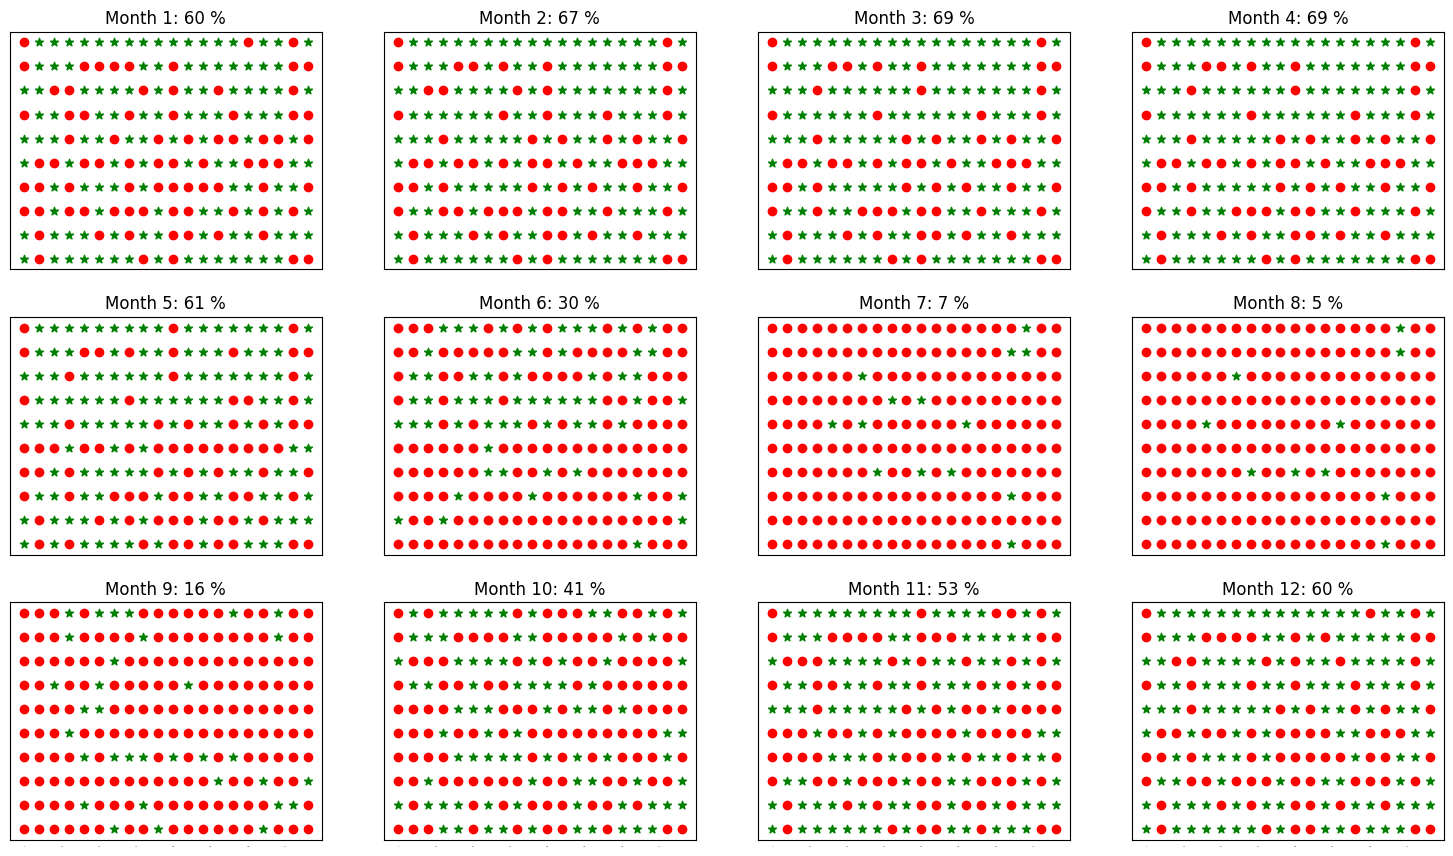

In [6]:
#BASIC MODEL WITH ENROLL for 3 month and only then can de enroll; Once enroll, agent can deenroll and re-enroll without binding
consumer_database.loc[:,"Contract months"]=0
consumer_database.loc[:,"Accumulated personal satisfaction"]=0
#consumer_database.loc[:,"Enrollment months"]=[]
consumer_database.loc[:,"Binding"]=0
for i in range(len(consumer_database)):
    #consumer_database["Satisfaction"].iloc[i]=[]
    consumer_database["Enrollment"].iloc[i]=[]
    consumer_database["Enrollment months"].iloc[i]=[]
for j in range(12):
    for i in range(len(consumer_database)):
        n=0
        friend=0
        weight_neighborhood=consumer_database["w_neighborhood"].iloc[i]
        weight_friends=consumer_database["w_friends"].iloc[i]
        weight_personal=consumer_database["w_personal"].iloc[i]
        if j==0:
            if consumer_database["Satisfaction"].iloc[i][j]==1:
                consumer_database["Enrollment"].iloc[i].append(1)
                consumer_database["Contract months"].iloc[i]=3
            else:
                consumer_database["Enrollment"].iloc[i].append(0)
                consumer_database["Contract months"].iloc[i]=0
        else:
            for k in range(n_friend_1):
                friend=friend+consumer_database["Satisfaction"].iloc[consumer_database["Friend group 1"].iloc[i][k]][j-1]
            for k in range(n_friend_2):
                friend=friend+consumer_database["Satisfaction"].iloc[consumer_database["Friend group 2"].iloc[i][k]][j-1]
            if consumer_database["Neighborhood"].iloc[i]==1:
                for k in neighborhood_1:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            elif consumer_database["Neighborhood"].iloc[i]==2:
                for k in neighborhood_2:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            elif consumer_database["Neighborhood"].iloc[i]==3:
                for k in neighborhood_3:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            else:
                for k in neighborhood_4:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            if consumer_database["Contract months"].iloc[i]==0:
                if consumer_database["Binding"].iloc[i]==1:
                    consumer_database["Accumulated personal satisfaction"].iloc[i]=\
                                        consumer_database["Satisfaction"].iloc[i][consumer_database["Enrollment months"].iloc[i][-1]]+\
                                        consumer_database["Satisfaction"].iloc[i][consumer_database["Enrollment months"].iloc[i][-2]]+\
                                        consumer_database["Satisfaction"].iloc[i][consumer_database["Enrollment months"].iloc[i][-3]]
                    e=weight_neighborhood*(n*4/consumers)+weight_friends*(friend/(n_friend_2+n_friend_1))+\
                    weight_personal*(consumer_database["Satisfaction"].iloc[i][j]+\
                    consumer_database["Accumulated personal satisfaction"].iloc[i]/3)/2  
                else:
                    consumer_database["Accumulated personal satisfaction"].iloc[i]=0
                    e=weight_neighborhood*(n*4/consumers)+weight_friends*(friend/(n_friend_2+n_friend_1))+\
                        weight_personal*(consumer_database["Satisfaction"].iloc[i][j]+\
                        consumer_database["Accumulated personal satisfaction"].iloc[i]/3)                    
                if e<0.5:
                    enroll=0
                    contract=0
                    consumer_database["Accumulated personal satisfaction"].iloc[i]=0
                else:
                    enroll=1
                    consumer_database["Enrollment months"].iloc[i].append(j)
                    if consumer_database["Binding"].iloc[i]==0:
                        contract=3
                    else:
                        contract=0
                consumer_database["Enrollment"].iloc[i].append(enroll)
                consumer_database["Contract months"].iloc[i]=contract
            elif consumer_database["Contract months"].iloc[i]>0:
                consumer_database["Enrollment months"].iloc[i].append(j)
                consumer_database["Enrollment"].iloc[i].append(1)
                if consumer_database["Contract months"].iloc[i]==1:
                    consumer_database["Binding"].iloc[i]=1
                consumer_database["Contract months"].iloc[i]=consumer_database["Contract months"].iloc[i]-1
            else:
                raise ValueError("ERROR!!! CHECK!! Contract months errors")
                
plot_x=0
fig, axs = plt.subplots(3,4, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
for m in range(12):    
    enrolled=[]
    not_enrolled=[]
    c=0
    for i in range(len(consumer_database)):
        if consumer_database["Enrollment"].iloc[i][m]==1:
            enrolled.append(i)
            c=c+1
        else:
            not_enrolled.append(i)
    plot_y=m%4
    axs[plot_x,plot_y].scatter(consumer_database["X"].loc[enrolled],consumer_database["Y"].loc[enrolled],marker="*",color="g")
    axs[plot_x,plot_y].scatter(consumer_database["X"].loc[not_enrolled],consumer_database["Y"].loc[not_enrolled],marker="o",color="r")
    axs[plot_x,plot_y].set_yticks([])
    axs[plot_x,plot_y].set_title(f"Month {m+1}: {int(c*100/consumers)} %")
    axs[plot_x,plot_y].tick_params(axis='both', labelsize=0, length = 0)
    if plot_y==3:
        plot_x=plot_x+1
    enrollment_rate_1["Enrollment 3"].iloc[m]=int(c*100/consumers)
    consumer_hp_enrolled=consumer_database.loc[consumer_database["Heating"]==1].index.intersection(enrolled)
    enrollment_rate_hp["Enrollment 3"].iloc[m]=len(consumer_hp_enrolled)/(electric_heating_share*consumers)
    consumer_pv_enrolled=consumer_database.loc[consumer_database["PV+BESS"]==1].index.intersection(enrolled)
    if pv_share!=0:
        enrollment_rate_pv["Enrollment 3"].iloc[m]=len(consumer_pv_enrolled)/(pv_share*consumers)
    else:
        enrollment_rate_pv["Enrollment 3"].iloc[m]=0
        

## Contract 4 where consumers have a 3 month binding period and then decide to enroll disenroll monthly. But once disenrolled, the consumer need to fulfill the binding period again

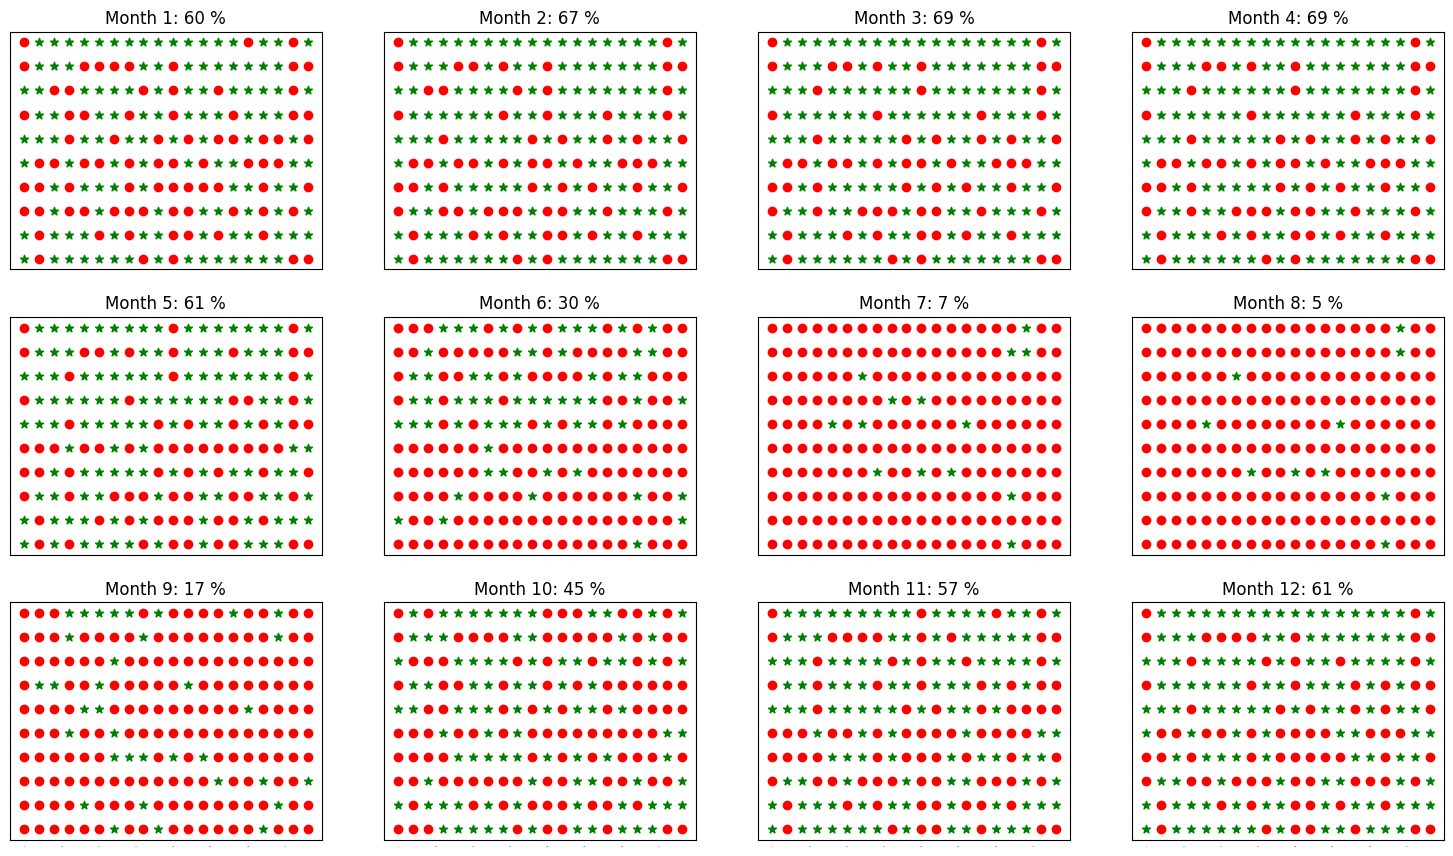

In [7]:
#BASIC MODEL WITH ENROLL for 3 month and only then can de enroll and when re-enrolling 3 month binding is needed
consumer_database.loc[:,"Contract months"]=0
consumer_database.loc[:,"Accumulated personal satisfaction"]=0
#consumer_database.loc[:,"Enrollment months"]=[]
consumer_database.loc[:,"Binding"]=0
for i in range(len(consumer_database)):
    #consumer_database["Satisfaction"].iloc[i]=[]
    consumer_database["Enrollment"].iloc[i]=[]
    consumer_database["Enrollment months"].iloc[i]=[]
for j in range(12):
    for i in range(len(consumer_database)):
        n=0
        friend=0
        weight_neighborhood=consumer_database["w_neighborhood"].iloc[i]
        weight_friends=consumer_database["w_friends"].iloc[i]
        weight_personal=consumer_database["w_personal"].iloc[i]
        if j==0:
            if consumer_database["Satisfaction"].iloc[i][j]==1:
                consumer_database["Enrollment"].iloc[i].append(1)
                consumer_database["Contract months"].iloc[i]=3
            else:
                consumer_database["Enrollment"].iloc[i].append(0)
                consumer_database["Contract months"].iloc[i]=0
        else:
            for k in range(n_friend_1):
                friend=friend+consumer_database["Satisfaction"].iloc[consumer_database["Friend group 1"].iloc[i][k]][j-1]
            for k in range(n_friend_2):
                friend=friend+consumer_database["Satisfaction"].iloc[consumer_database["Friend group 2"].iloc[i][k]][j-1]
            if consumer_database["Neighborhood"].iloc[i]==1:
                for k in neighborhood_1:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            elif consumer_database["Neighborhood"].iloc[i]==2:
                for k in neighborhood_2:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            elif consumer_database["Neighborhood"].iloc[i]==3:
                for k in neighborhood_3:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            else:
                for k in neighborhood_4:
                    n=n+consumer_database["Enrollment"].loc[k][j-1]
            if consumer_database["Contract months"].iloc[i]==0:
                if consumer_database["Binding"].iloc[i]==1:
                    consumer_database["Accumulated personal satisfaction"].iloc[i]=\
                                        consumer_database["Satisfaction"].iloc[i][consumer_database["Enrollment months"].iloc[i][-1]]+\
                                        consumer_database["Satisfaction"].iloc[i][consumer_database["Enrollment months"].iloc[i][-2]]+\
                                        consumer_database["Satisfaction"].iloc[i][consumer_database["Enrollment months"].iloc[i][-3]]
                    e=weight_neighborhood*(n*4/consumers)+weight_friends*(friend/(n_friend_2+n_friend_1))+\
                        weight_personal*(consumer_database["Satisfaction"].iloc[i][j]+\
                        consumer_database["Accumulated personal satisfaction"].iloc[i]/3)/2   
                else:
                    consumer_database["Accumulated personal satisfaction"].iloc[i]=0
                    e=weight_neighborhood*(n*4/consumers)+weight_friends*(friend/(n_friend_2+n_friend_1))+\
                        weight_personal*(consumer_database["Satisfaction"].iloc[i][j]+\
                        consumer_database["Accumulated personal satisfaction"].iloc[i]/3)                    
                if e<0.5:
                    enroll=0
                    contract=0
                    consumer_database["Binding"].iloc[i]=0
                    consumer_database["Accumulated personal satisfaction"].iloc[i]=0
                else:
                    enroll=1
                    consumer_database["Enrollment months"].iloc[i].append(j)
                    if consumer_database["Binding"].iloc[i]==0:
                        contract=3
                    else:
                        contract=0
                consumer_database["Enrollment"].iloc[i].append(enroll)
                consumer_database["Contract months"].iloc[i]=contract
            elif consumer_database["Contract months"].iloc[i]>0:
                consumer_database["Enrollment months"].iloc[i].append(j)
                consumer_database["Enrollment"].iloc[i].append(1)
                if consumer_database["Contract months"].iloc[i]==1:
                    consumer_database["Binding"].iloc[i]=1
                consumer_database["Contract months"].iloc[i]=consumer_database["Contract months"].iloc[i]-1
            else:
                raise ValueError("ERROR!!! CHECK!! Contract months errors")
                
plot_x=0
fig, axs = plt.subplots(3,4, sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)
for m in range(12):    
    enrolled=[]
    not_enrolled=[]
    c=0
    for i in range(len(consumer_database)):
        if consumer_database["Enrollment"].iloc[i][m]==1:
            enrolled.append(i)
            c=c+1
        else:
            not_enrolled.append(i)
    plot_y=m%4
    axs[plot_x,plot_y].scatter(consumer_database["X"].loc[enrolled],consumer_database["Y"].loc[enrolled],marker="*",color="g")
    axs[plot_x,plot_y].scatter(consumer_database["X"].loc[not_enrolled],consumer_database["Y"].loc[not_enrolled],marker="o",color="r")
    axs[plot_x,plot_y].set_yticks([])
    axs[plot_x,plot_y].set_title(f"Month {m+1}: {int(c*100/consumers)} %")
    axs[plot_x,plot_y].tick_params(axis='both', labelsize=0, length = 0)
    if plot_y==3:
        plot_x=plot_x+1
    enrollment_rate_1["Enrollment 4"].iloc[m]=int(c*100/consumers)
    consumer_hp_enrolled=consumer_database.loc[consumer_database["Heating"]==1].index.intersection(enrolled)
    enrollment_rate_hp["Enrollment 4"].iloc[m]=len(consumer_hp_enrolled)/(electric_heating_share*consumers)
    consumer_pv_enrolled=consumer_database.loc[consumer_database["PV+BESS"]==1].index.intersection(enrolled)
    if pv_share!=0:
        enrollment_rate_pv["Enrollment 4"].iloc[m]=len(consumer_pv_enrolled)/(pv_share*consumers)
    else:
        enrollment_rate_pv["Enrollment 4"].iloc[m]=0

### Plotting the enrollment rates

(0.0, 110.0)

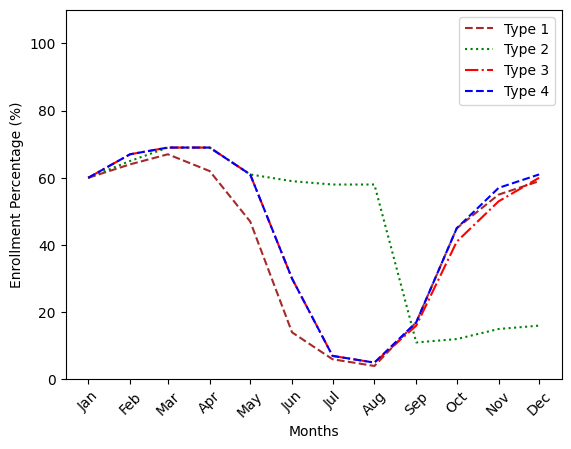

In [8]:
#plt.figure()
ax = plt.gca()
ax.plot(start_month,enrollment_rate_1["Enrollment 1"],label="Type 1",color="brown",linestyle="dashed")
ax.plot(start_month,enrollment_rate_1["Enrollment 2"],label="Type 2",color="green",linestyle="dotted")
ax.plot(start_month,enrollment_rate_1["Enrollment 3"],label="Type 3",color="red",linestyle="dashdot")
ax.plot(start_month,enrollment_rate_1["Enrollment 4"],label="Type 4",color="blue",linestyle="dashed")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlabel("Months")
ax.set_ylabel("Enrollment Percentage (%)")
plt.legend()
plt.setp(ax.get_xticklabels(), rotation=45) 
plt.ylim(0,110)

(0.0, 110.0)

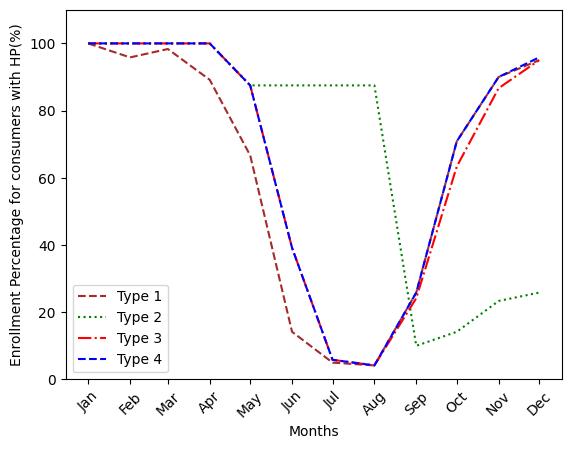

In [9]:
ax = plt.gca()
ax.plot(start_month,enrollment_rate_hp["Enrollment 1"]*100,label="Type 1",color="brown",linestyle="dashed")
ax.plot(start_month,enrollment_rate_hp["Enrollment 2"]*100,label="Type 2",color="green",linestyle="dotted")
ax.plot(start_month,enrollment_rate_hp["Enrollment 3"]*100,label="Type 3",color="red",linestyle="dashdot")
ax.plot(start_month,enrollment_rate_hp["Enrollment 4"]*100,label="Type 4",color="blue",linestyle="dashed")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel("Months")
plt.setp(ax.get_xticklabels(), rotation=45) 
plt.ylabel("Enrollment Percentage for consumers with HP(%)")
#plt.title(f"Randomly assigned weights for all consumers")
plt.legend()
plt.ylim(0,110)
#plt.savefig(r'\\maa1.cc.lut.fi\home\z102933\Documents\PhD\Data\ABM\output4.png')

(0.0, 110.0)

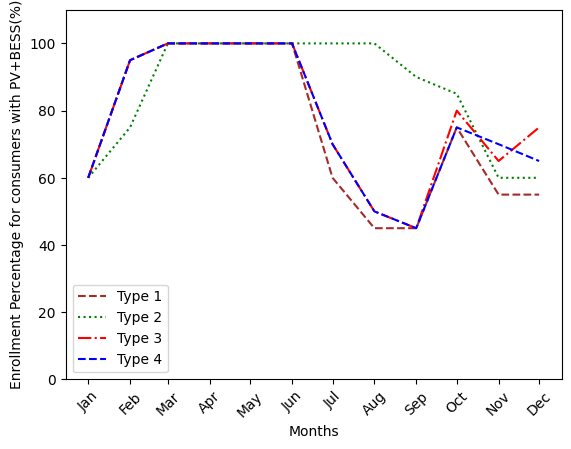

In [10]:
ax = plt.gca()
ax.plot(start_month,enrollment_rate_pv["Enrollment 1"]*100,label="Type 1",color="brown",linestyle="dashed")
ax.plot(start_month,enrollment_rate_pv["Enrollment 2"]*100,label="Type 2",color="green",linestyle="dotted")
ax.plot(start_month,enrollment_rate_pv["Enrollment 3"]*100,label="Type 3",color="red",linestyle="dashdot")
ax.plot(start_month,enrollment_rate_pv["Enrollment 4"]*100,label="Type 4",color="blue",linestyle="dashed")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,13,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel("Months")
plt.setp(ax.get_xticklabels(), rotation=45) 
plt.ylabel("Enrollment Percentage for consumers with PV+BESS(%)")
#plt.title(f"Randomly assigned weights for all consumers")
plt.legend()
plt.ylim(0,110)
#plt.savefig(r'\\maa1.cc.lut.fi\home\z102933\Documents\PhD\Data\ABM\output4.png')